In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
matplotlib.rcParams.update({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'pgf.rcfonts': False,
                            "savefig.transparent" : True,  "svg.fonttype": 'none',  })
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc("svg", fonttype='none')
plt.rc('text.latex', preamble=
       r'\usepackage{amsmath}'\
       + "\n" + r'\usepackage{amssymb}'
       )
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import tqdm
import collections.abc
import torch
from utils import PredictionResults, color
import os
import matplotlib.transforms
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
import matplotlib.figure
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation
import yaml 
import torch.utils.data as torchdata

print(os.getenv("PYTHONPATH"))
print(sys.path)

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils

In [ ]:
keys : set = {
    "hist",
    "hist_tangents",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "thistory",
    "tfuture",
    "current_position",
    "current_orientation" 
}
with open("config.yaml", "r") as f:
    configdict : dict = yaml.safe_load(f)
realdata : bool = configdict["realdata"]
data_dir = "/p/DeepRacing/unpacked_datasets/iac_data_v3/deepracing_standard" if realdata \
           else "/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard"
mtr_data_dir = os.path.join(os.path.dirname(data_dir), "mtr_format", "1second")
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files(data_dir,
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

if realdata:
    bezier_experiment = "registered_ottoman_7483"
    bezier_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/bezier_mixnet", bezier_experiment)
    composite_experiment = "musical_raccoon_7407" #encouraging_corolla_2210 musical_raccoon_7407
    composite_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/barte", composite_experiment)
    mixnet_experiment = "symbolic_varnish_9248"
    mixnet_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mixnet", mixnet_experiment)
    mtr_experiment = "worldwide_perch_1278"
    mtr_results_dir =  os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mtr", mtr_experiment)
else:
    bezier_experiment = "widespread_beans_6059"
    bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
    composite_experiment = "chosen_preservative_7505"
    composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
    mixnet_experiment = "agricultural_flue_8932"
    mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
    mtr_experiment = "formal_pedestal_9890"
    mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/sim_data", mtr_experiment, "test_plots")


bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BézierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
# if not realdata:
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "data.npz"), "MTR")
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
# (126577, 80, 2)
mtr_results["ground_truth"] = np.concatenate([mtr_results["ground_truth"], np.zeros_like(mtr_results["ground_truth"][:,:,[0,]])], axis=-1)
mtr_results["predictions"] = np.concatenate([mtr_results["predictions"], np.zeros_like(mtr_results["predictions"][:,:,[0,]])], axis=-1)
mtr_results.compute_fde()

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))


all_results_composite_ref = [composite_results, mtr_results, bezier_results, mixnet_results]
all_results_mtr_ref = [mtr_results, composite_results, bezier_results, mixnet_results]
base_path="/p/DeepRacing/trajectory_prediction_results"

In [ ]:


# tfuture_all = torch.stack([torch.as_tensor(fulldset[i]["tfuture"], **devicedtype) for i in range(len(fulldset))])
# gt_vel_all = torch.stack([torch.as_tensor(fulldset[i]["fut_vel"], **devicedtype) for i in range(len(fulldset))])
# gt_all = torch.stack([torch.as_tensor(fulldset[i]["fut"], **devicedtype) for i in range(len(fulldset))])

# gtfit_all, _ = mu.compositeBezierFit(tfuture_all, gt_all, Nseg, constraint_level=2, kbezier=kbezier, dYdT_0=gt_vel_all[:,0], dYdT_f=gt_vel_all[:,-1])

113154


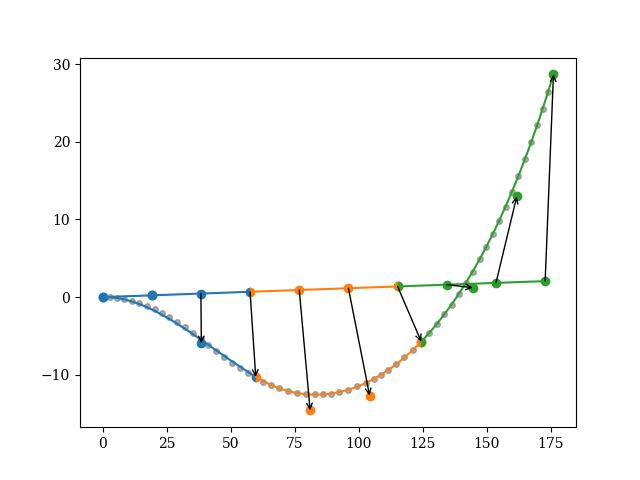

In [35]:
%matplotlib widget
%autoreload 2
import utils
idx_rand = int(np.random.randint(0, high=len(fulldset), size=1)[0])
# idx_rand = 101355
idx_rand = 113154
# idx_rand = 13330
# idx_rand = 44498
# idx_rand = 114110

print(idx_rand)
sample = fulldset[idx_rand]
qmask = np.ones(4, dtype=np.float64)
pmask = np.ones(3, dtype=np.float64)
# qmask[0] = qmask[1] = 0.0
# pmask[2] = 0.0
devicedtype = {"dtype" : torch.float64, "device" : torch.device("cuda:0")}
current_position = sample["current_position"]*pmask
current_orientation = Rotation.from_quat(sample["current_orientation"]*qmask)
history, history_global = torch.as_tensor(sample["hist"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["hist"]) + current_position, **devicedtype)
ground_truth, ground_truth_global = torch.as_tensor(sample["fut"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["fut"]) + current_position, **devicedtype)
future_left_bd, future_left_bd_global = torch.as_tensor(sample["future_left_bd"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["future_left_bd"]) + current_position, **devicedtype)
future_right_bd, future_right_bd_global = torch.as_tensor(sample["future_right_bd"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["future_right_bd"]) + current_position, **devicedtype)


history_vel, history_vel_global = torch.as_tensor(sample["hist_vel"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["hist_vel"]), **devicedtype)
future_vel, future_vel_global = torch.as_tensor(sample["fut_vel"].copy(), **devicedtype), torch.as_tensor(current_orientation.apply(sample["fut_vel"]), **devicedtype)
thistory = torch.as_tensor(sample["thistory"].copy(), **devicedtype)
tfuture = torch.as_tensor(sample["tfuture"].copy(), **devicedtype)
t0 = tfuture[0].item()
thistory = thistory - t0
tfuture = tfuture - t0
Nseg = 3
kbezier = 3
tswitch : torch.Tensor = torch.linspace(tfuture[0], tfuture[-1], steps=Nseg+1, **devicedtype)
tstart = tswitch[:-1]
dT = tswitch[1:] - tswitch[:-1]
nu0 = torch.ones([Nseg, kbezier, future_vel.shape[-1]], **devicedtype)*future_vel[None,None,0]
cbc_straightline = mu.compositeBezierAntiderivative(nu0, dT)
cbc_gt_full, _ = mu.compositeBezierFit(tfuture, ground_truth, Nseg, constraint_level=2, kbezier=kbezier, dYdT_0=future_vel[0], dYdT_f=future_vel[-1])
cbc_delta = cbc_gt_full - cbc_straightline

# cbc_gt = cbc_gt[0]
try:
    plt.close(fig=fig0) # type: ignore
except:
    pass
fig0 = plt.figure() #"s" : 5**2,
ax0 = fig0.add_subplot()
# colors = None
# base_artists = None
scatterargs = {"tplot" : tfuture.cpu(), "tswitch" : tswitch.cpu(), "visible" : True}
def init_func():
    global colors, base_artists, scatterargs, ax0
    try:
        ax0.clear()
    except:
        pass
    colors, _, base_artists = utils.scatter_composite_xy(cbc_straightline[:,:,[0,1]].cpu(), ax0, **scatterargs)
    base_artists.append(ax0.scatter(ground_truth[:,0].cpu(), ground_truth[:,1].cpu(), s=2**4.0, color="grey", alpha=0.65))
    scatterargs["visible"] = False
    return base_artists
new_artists =[]
def partial_offset(ax, ratio : float):
    global fig0, base_artists, new_artists, cbc_straightline, cbc_delta, scatterargs, kbezier, Nseg
    for artist in new_artists:
        artist.remove()
    cbc_gt = cbc_straightline + ratio*cbc_delta
    _, points_plot, new_artists = utils.scatter_composite_xy(cbc_gt[:,:,[0,1]].cpu(), ax, colors = colors, **scatterargs)
    arrowprops=dict(facecolor='black', arrowstyle='->', shrinkA=0,shrinkB=0)
    for i in range(Nseg):
        idxpoints = torch.arange(2, kbezier+1, step=1, dtype=torch.int64) if i==0 else torch.arange(1, kbezier+1, step=1, dtype=torch.int64)
        p0vec = cbc_straightline[i, idxpoints].cpu().numpy()
        pfvec = cbc_gt[i, idxpoints].cpu().numpy()
        for j in range(p0vec.shape[0]):
            p0 = p0vec[j,:2]
            pf = pfvec[j,:2] #visible=scatterargs["visible"], 
            new_artists.append(ax.annotate("", pf, xytext=p0, arrowprops=arrowprops))
    return base_artists + new_artists
        
import functools
boundfunc = functools.partial(partial_offset, ax0)
import matplotlib.animation

animation = matplotlib.animation.FuncAnimation(fig0, boundfunc, frames=torch.linspace(0.0, 1.0, steps=60).cpu().numpy().tolist(), init_func=init_func, interval=7, repeat=False)

animation.save(os.path.join(os.environ["HOME"], "asdf.mp4"))
